In [1]:
suppressMessages(library(MASS))
suppressMessages(library(tidyverse))
suppressMessages(library(matrixStats))
suppressMessages(library(parallel))
suppressMessages(library(caret))
suppressMessages(library(rpart))
suppressMessages(library(bst))
suppressMessages(library(randomForest))
suppressMessages(library(repr))
suppressMessages(library(patchwork))

options(repr.plot.width=30, repr.plot.height=8)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


We decided to implement many of the methods ourselves to give you a more easily understandable framework for the later stages of the presentation, when we opted to use packages due to runtime.

In [2]:
#Setting seed for reprudicibility 
set.seed(358434829)

# number of observations
n_train <- 500
n_test <- 100
n <- n_train + n_test

We chose to use 20 regressors with ~5 interaction terms as our testing showed that some of these methods strive in settings with many low impact predictors and high noise.

In [3]:
# number of regressors
p <- 20

# target number of interaction effects (for simplicity covariates c)
target_int_terms <- 5

# maximum number of factors in interaction effect
int_limit <- 4

interactions <- unique(map(.x = 1:target_int_terms,
                           .f = function(i) sort(sample(x = 1:p, size = sample(2:int_limit), replace = TRUE))))

int_terms <- length(interactions)    

For our setup we chose to implement the data generating process such that it can generate not only independent regressors, but general multivariate normal regressors.                

In [4]:
my_mu <- runif(n = p, min = -1, max = 1)
A <- diag(rep(1, times = p))
my_Sigma <- t(A) %*% A

As we wanted each term to only have a small impact on the outcome variable, the chosen coefficients are rather small. Especially for the interaction terms the coeeficients were choses rather small to achieve a better performance of boosting in this setting. The idea is to allow for useful rule of thumbs in the boosting process, that do not depend on complex multidimensional interactions as these cannot easily by covered by weak learners as the small trees with few nodes used in the boosting algorithm. 

In [5]:
theta <- c(runif(n = p, min = -0.5, max = 0.5), runif(n = int_terms, min = -0.2, max = 0.2))      
print(theta)

 [1]  0.07339208 -0.33186535  0.45395131  0.01876268 -0.18779360 -0.12309211
 [7]  0.25180177 -0.42991212 -0.30912512 -0.15616228 -0.00846771  0.37535189
[13]  0.34466063  0.34905158 -0.23910220  0.27260956  0.07722504 -0.06492965
[19]  0.06668918  0.23657978  0.10079161  0.16725504 -0.15644508  0.16702938
[25] -0.12306892


The data generating process is not only non-linear due to the incorporation of interaction terms, but also due to a transformation with the logistic function. \
In a one dimensional setting this leads to function like this:

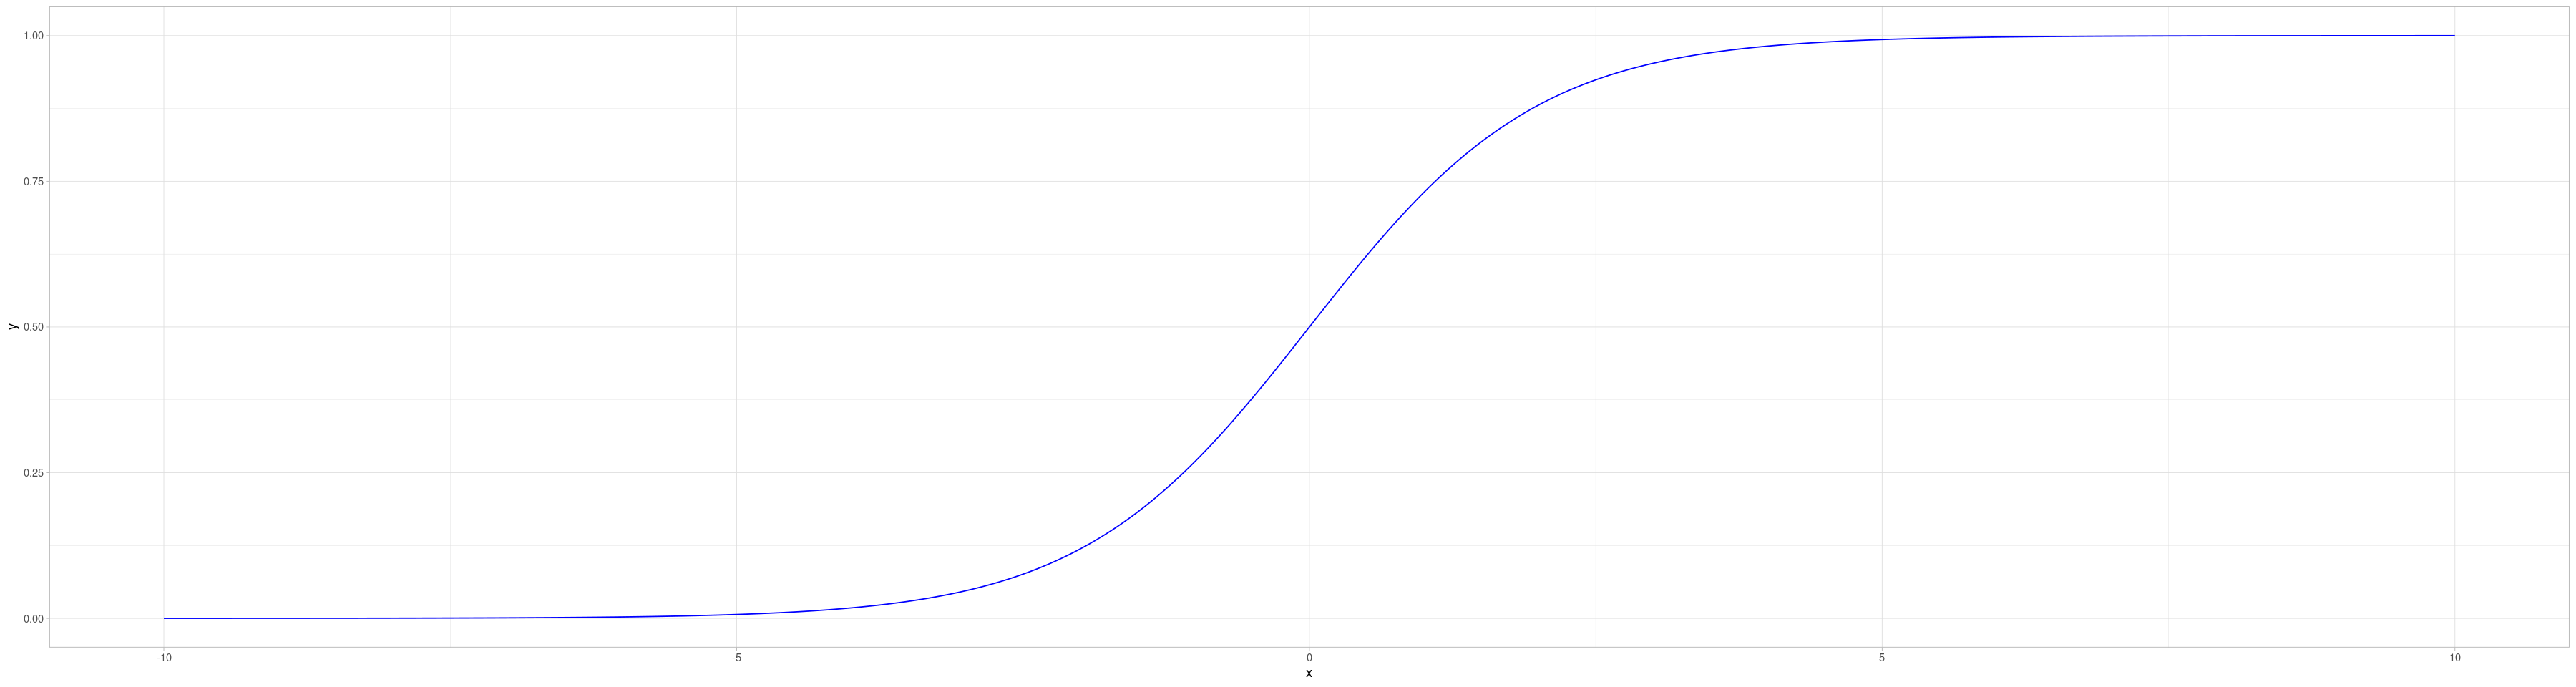

In [6]:
plot_tibble <- tibble(x = seq(-10, 10, length.out = 1000),
                      y = 1/(1+exp(-x)))
ggplot(plot_tibble) +
    geom_line(aes(x=x, y=y), col = "blue") +
    theme_light()

To explain the functional form we chose let us think about how different ensemble methods learn from data.
1. boosting (which is what we tried to accomodate with our choice of dgp) iteratively fits small trees to the model, each of which can only model a rather simple rule of thumb. <br>
To look at how this is different from a standard regression tree, let's create some graphics: (this is a simple visualization of what boosting does with $\lambda = 1$. (These are just eyeballed, so do not take the numerical values to seriously.)

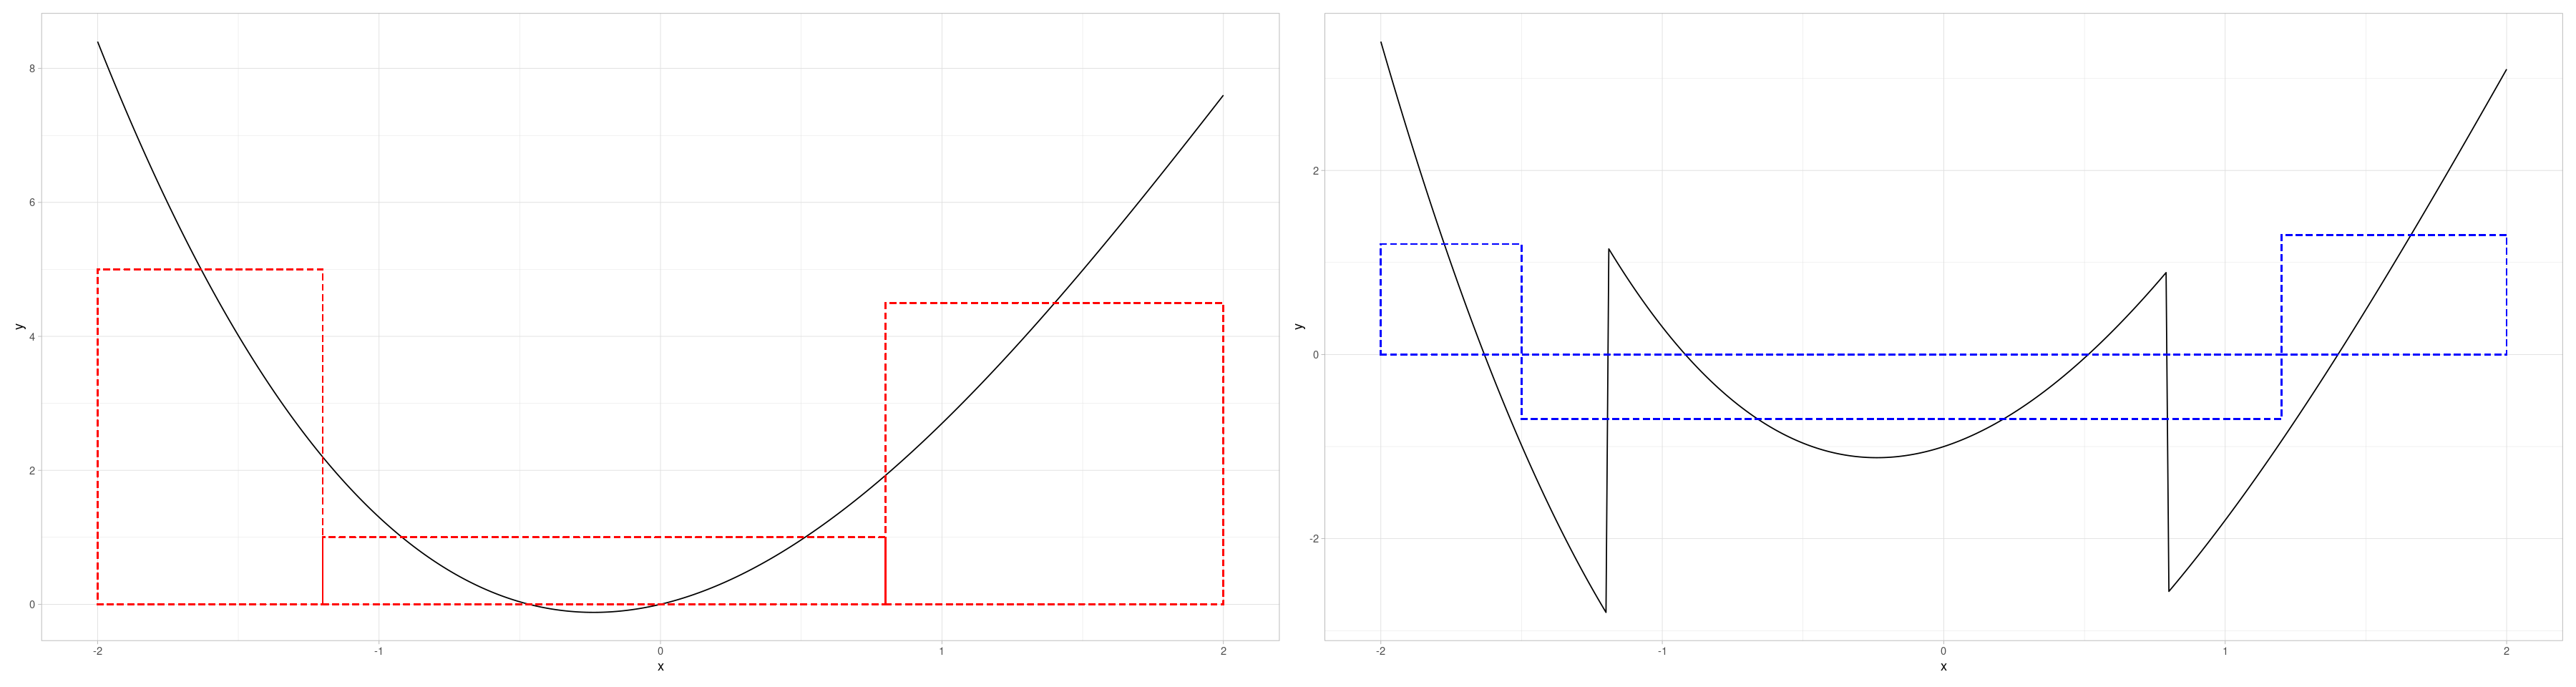

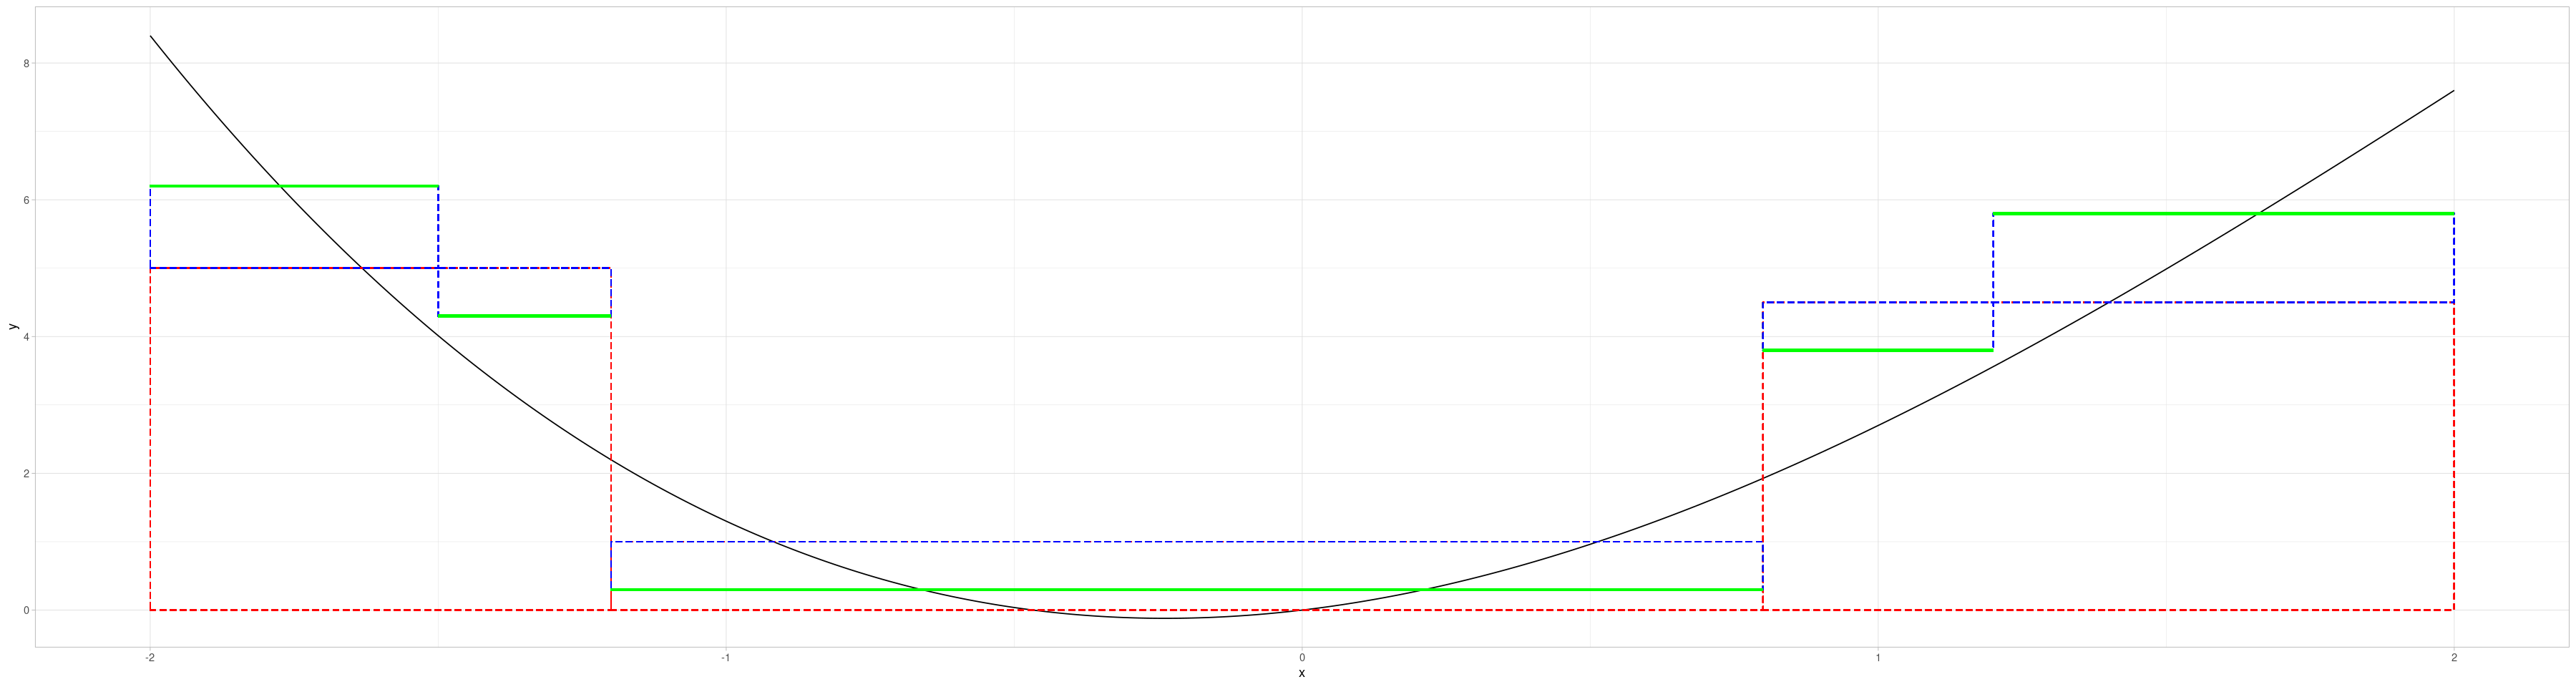

In [7]:
start <- tibble(x = seq(-2, 2, 0.01),
                y = - 0.3*x^3 + 2*x^2 + x)

first_iter <- tibble(x = seq(-2, 2, 0.01),
                     y = c(start$y[start$x <= -1.2] - 5, start$y[(start$x > -1.2) & (start$x <= 0.8)] - 1, start$y[start$x > 0.8] - 4.5))

second_iter <- tibble(x = seq(-2, 2, 0.01),
                      y = c(first_iter$y[start$x <= -1.5] - 1.2, first_iter$y[(start$x > -1.5) & (start$x <= 1.2)] + 0.7, first_iter$y[start$x > 1.2] - 1.3))


p1 <- ggplot(data = start) +
    geom_line(aes(x = x, y = y), size = 0.5) +
    geom_rect(xmin = -2, xmax = -1.2, ymin = 0, ymax = 5, col = "red", fill = NA, size = 0.5, lty = 2) +
    geom_rect(xmin = -1.2, xmax = 0.8, ymin = 0, ymax = 1, col = "red", fill = NA, size = 0.5, lty = 2) +
    geom_rect(xmin = 0.8, xmax = 2, ymin = 0, ymax = 4.5, col = "red", fill = NA, size = 0.5, lty = 2) +
    theme_light()

p2 <- ggplot(data = first_iter) +
    geom_line(aes(x = x, y = y), size = 0.5) +
    geom_rect(xmin = -2, xmax = -1.5, ymin = 0, ymax = 1.2, col = "blue", fill = NA, size = 0.5, lty = 2) +
    geom_rect(xmin = -1.5, xmax = 1.2, ymin = -0.7, ymax = 0, col = "blue", fill = NA, size = 0.5, lty = 2) +
    geom_rect(xmin = 1.2, xmax = 2, ymin = 0, ymax = 1.3, col = "blue", fill = NA, size = 0.5, lty = 2) +
    theme_light()

p1 + p2

p4 <- ggplot(data = start) +
    geom_line(aes(x = x, y = y), size = 0.5) +
    geom_rect(xmin = -2, xmax = -1.2, ymin = 0, ymax = 5, col = "red", fill = NA, size = 0.5, lty = 2) +
    geom_rect(xmin = -1.2, xmax = 0.8, ymin = 0, ymax = 1, col = "red", fill = NA, size = 0.5, lty = 2) +
    geom_rect(xmin = 0.8, xmax = 2, ymin = 0, ymax = 4.5, col = "red", fill = NA, size = 0.5, lty = 2) +
        geom_rect(xmin = -2, xmax = -1.5, ymin = 5, ymax = 6.2, col = "blue", fill = NA, size = 0.5, lty = 2) +
        geom_rect(xmin = -1.5, xmax = -1.2, ymin = 4.3, ymax = 5, col = "blue", fill = NA, size = 0.5, lty = 2) +
        geom_rect(xmin = -1.2, xmax = 0.8, ymin = 0.3, ymax = 1, col = "blue", fill = NA, size = 0.5, lty = 2) +
        geom_rect(xmin = 0.8, xmax = 1.2, ymin = 3.8, ymax = 4.5, col = "blue", fill = NA, size = 0.5, lty = 2) +
        geom_rect(xmin = 1.2, xmax = 2, ymin = 4.5, ymax = 5.8, col = "blue", fill = NA, size = 0.5, lty = 2) +
    geom_segment(aes(x = -2, xend = -1.5, y = 6.2, yend = 6.2), col = "green", size = 1) +
    geom_segment(aes(x = -1.5, xend = -1.2, y = 4.3, yend = 4.3), col = "green", size = 1) +
    geom_segment(aes(x = -1.2, xend = 0.8, y = 0.3, yend = 0.3), col = "green", size = 1) +
    geom_segment(aes(x = 0.8, xend = 1.2, y = 3.8, yend = 3.8), col = "green", size = 1) +
    geom_segment(aes(x = 1.2, xend = 2, y = 5.8, yend = 5.8), col = "green", size = 1) +
    theme_light()

p4

This intuition can be generalied to more dimensions quite easily be replacing segemnts of the real line with a partition of the space of covariates along hyperplanes each intersecting oly one axis. <br> In two dimensions imagine the following:
* You have some Lego and a piece of cloth hovering in the air that you can only see slightly blurry.
* In each iteration you can partition your building surface into a small number of rectangles. In each reactngle you can only ever add or subtract the same height in Lego bricks.
* Since the rectangles don't have to be identical over iterations, this can result in differing heights.
* You try to approximate the shape of the hovering cloth as closely as possible with the top of your Lego object. 

So in p dimensions for boosting to work well we want a dgp that can be easily approximated by the following process:
1. Set $k=0$ and  $r_{0,i} = y_{i}$
2. Choose a low number of hyperplanes each intersecting only one axis of our space of covariates to minimize a criterion of $r_{k}$ as described in the lecture.
3. Calculate the mean of the $r_{k,i}$ in each disjunct subset of the space of covariates created by the hyperplanes.
4. Set $r_{k+1,i}$ by subtracting the appropriate mean from each residual (the mean from the subset, where the observation lies in)
5. Set $k = k+1$
6. Go to 2.

To see why this makes some properties of the dgp desirable look at the following:
In a linear process <br> $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2$  <br> a rule of thumb based on whether or not $X_1$ takes a high value can be extended to the whole range of $X_2$. So an iterative process based on very small trees might reasonably be able to cover this with a few iterations. <br> 
Contrary to this: <br> $Y = \beta_0 + \beta_1 X_1 + \gamma sin(X_1)X_2$ <br> Here the effect of $X_2$ heavily depends on the value of $X_1$. So a rule of thumb only depending on $X_2$ might not contain that much information in itself. An algorithm based on small trees might struggle to quickly (with few iterations) replicate this interaction. 
These are simple examples that could very easily be "decoded" by boosting. But in higher dimensions with more complex interaction terms this can become a problem for boosting methods. 

So for a DGP that suits a boosting algorithm we want to have quite general rule of thumbs that do not heavily depend on complex interactions with other variables.

In [21]:
dgp <- function(n, my_mu, my_sigma, theta, interactions){

    X <- mvrnorm(n = n, mu = my_mu, Sigma = my_Sigma)
    int_X <- simplify2array(map(.x = interactions,
                                .f = function(int_ind) rowProds(X[,int_ind])))
                                
    eps_1 <- rnorm(n = dim(X)[1])
    eps_2 <- rnorm(n = dim(X)[1])                                
    tmp <- cbind(X, int_X)                            
    
    probs <- 1 / (1 + exp(-tmp %*% theta + eps_1))                                
                                
    Y <- 100*probs + eps_2 #rbinom(n = dim(X)[1], size = 1, prob = probs) + eps_2))
    my_data <- cbind(data.frame(Y = Y), tmp)
    
    names(my_data) <- c("Y", paste0("X_", as.character(1:p)), 
                           unlist(map(.x = interactions,
                                      .f = function(int) paste(paste0("X_", as.character(int)), collapse = "*"))))
                                      
    row.names(my_data) <- as.character(1:n)  
    return(my_data)
}                            
                                                                                   
my_data <- dgp(n = n, my_mu, my_Sigma, theta, interactions)                                      
                                                                       
train <- my_data[1:n_train,]
test <- my_data[(n_train+1):n,]

head(my_data) 
summary(my_data$Y)                                                                            

,Y,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,⋯,X_16,X_17,X_18,X_19,X_20,X_4*X_6*X_14*X_18,X_5*X_16,X_3*X_5*X_10*X_17,X_1*X_7*X_12*X_13,X_6*X_10*X_15*X_17
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,97.24729,-0.2662193,2.2006452,-1.49767404,-0.24601726,1.86710412,0.9374363,-0.5958075,-1.07976668,-1.9716882,⋯,0.71422164,-1.5644616,0.9033076,0.3002096,1.783291,0.16788131,1.333526172,-11.946096702,0.001149562,-1.57797326
2,18.34665,-0.5507359,2.8252858,-1.60699587,-0.01391161,1.40949505,1.2177250,-1.3518012,-1.84485428,1.0026006,⋯,0.26633780,-1.4190687,1.6034502,2.2970165,1.664311,0.07965269,0.375401814,-2.803027302,-0.090387909,0.44276957
3,75.29710,-0.4475694,0.7762479,1.07278671,0.22923148,1.74559042,1.6225891,0.2595997,-0.03216946,-0.4485981,⋯,-1.54420456,-0.6400293,0.4893672,1.4460777,1.486284,-0.25891576,-2.695548698,2.215836595,0.392810945,-3.31123202
4,37.10063,-0.8187656,0.8077126,-2.72842059,1.38398762,1.10596043,0.3496397,0.4057677,-1.14235265,-2.7426229,⋯,-0.86150458,-0.7380978,1.6431623,2.4546223,1.473908,-0.82854626,-0.952789975,-4.552040334,-0.414395658,-0.29027087
5,76.12451,-0.8025591,0.7469187,-0.02066064,-0.22842409,-0.03044756,1.2376493,-0.3761892,0.13719182,-0.7354403,⋯,0.06128459,-1.2698157,0.6086477,-0.5123206,-1.326599,0.10540144,-0.001865966,0.001578294,-0.037783699,1.02134722
6,85.80457,-2.8294651,0.2544604,1.12922617,0.13337092,-0.47296599,0.9290900,-1.4897104,0.13189765,-1.4456015,⋯,-2.34448338,0.2286228,0.5066092,0.9479973,1.532975,-0.05803787,1.108860894,0.081252165,12.374687372,0.07067162


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.599  10.926  29.159  35.449  56.926  97.463 

We decided to implement Random Forest as a sencond ensemble method as it follows a different approach. To see this consider the following analogy: <br>
In nonparametric Kernel regression we face a tradeoff between bias and variance when choosing the bandwidth. When choosing a very large bandwidth a local linear estimator will converge to the OLS estimate (under some reasonable assumptions for the data) and therefore minimize variance while suffering from bias, whereas choosing an infinitessimaly low bandwidth will have no bias (again under some assumptions) but high variance and tend to overfit. <br>

Choosing the number of splits in a tree is a similar endeavour. Choosing a high number of splits (for example resulting in a number of leafs equal to the number of observations) will have small bias but high variance, whereas a small tree will have high bias but low variance. So the ideas to improve the estimation depends on what kind of tree we want to use.
* If we use small trees, our method should try to reduce BIAS. This is what Boosting does iteratively.
* If we use large trees (for example full grown decision trees), our method should reduce variance. This is what bagging or random forest does by averaging the decision of multiple full grown trees.

In the Lego example, the latter would mean to build many very intricate trees without having to adhere to some iterative process. But you can only look at randomly chosen parts of the cloth each time. (In two dimensions random forest is difficult to imagine, but in higher dimensions, you could only place your hyperplanes intersecting specific axes.) When in the end you want to approximate the cloth, you choose the average height of your towers in each point.

QUESTIONS?

To implement regression trees and random forest we used the following guides with some heavy modifications, as for example random forest was incorrectly implemented.

Following a guide from Andre Bleier on statworx.com (09.11.2018)\
https://www.statworx.com/blog/coding-regression-trees-in-150-lines-of-code \
Some modifications: avoid loops, use map instead of apply etc.

Following a guide from Andre Bleier on r-bloggers.com (09.11.2018)\
https://www.r-bloggers.com/2019/06/coding-random-forests-in-100-lines-of-code/ \
Some modifications: parallelization and fixing important problems with implementation (was branded as random forest, didn't implement random forest)

In [9]:
### following a guide from Andre Bleier on statworx.com (09.11.2018)
# https://www.statworx.com/blog/coding-regression-trees-in-150-lines-of-code
# Some modifications (avoid loops, use map instead of apply etc.)

criterion <- function(x, y) {
  splits <- sort(unique(x))
  sse <- unlist(map(
    .x = splits,
    .f = function(sp) {
      sum((y[x < sp] - mean(y[x < sp]))^2) + sum((y[x >= sp] - mean(y[x >= sp]))^2)
    }
  ))
  split_at <- which.min(sse)
  return(list(criterion = sse[split_at], split = splits[split_at]))
}

importance <- function(y) {
  return(mean((y - mean(y, na.rm = TRUE))^2))
}

reg_tree_imp <- function(formula, data, minsize, feature_frac, bs = FALSE) {
  data <- as.data.frame(data)
    
  if(bs == TRUE){  
  data <- data[sample(1:dim(data)[1], size = dim(data)[1], replace = TRUE), ]
  }
    
  formula <- terms.formula(formula)
  features <- all.vars(formula)[-1]
  X <- model.matrix(formula, data)
  y <- data[, as.character(formula)[2]]

  tree_info <- tibble(
    NODE = 1, NOBS = nrow(data), FILTER = NA_character_,
    TERMINAL = "SPLIT", IMP_GINI = NA_real_, SPLIT = NA_character_, VALUE = NA_real_
  )

  do_splits <- TRUE

  while (do_splits) {
    to_calculate <- which(tree_info$TERMINAL == "SPLIT")

    for (j in to_calculate) {
      if (!is.na(tree_info[j, "FILTER"])) {
        this_data <- subset(data, eval(parse(text = tree_info[j, "FILTER"])))
        X <- model.matrix(formula, this_data)
      }
      else {
        this_data <- data
      }

      tmp <- map(
        .x = 1:dim(X)[2],
        .f = function(i) X[, i]
      )[-1]
        
      tmp_ind <- sample(1:length(tmp), size = ceiling(length(features) * feature_frac), replace = FALSE)
      tmp <- tmp[tmp_ind]
        
      splitting <- matrix(data = unlist(map(
        .x = tmp,
        .f = function(x) unlist(criterion(x = x, y = this_data[[all.vars(formula)[1]]]))
      )), nrow = 2, byrow = FALSE)

      tmp_splitter <- which.min(splitting[1, ])
      names(tmp_splitter) <- all.vars(formula)[tmp_ind[tmp_splitter] + 1]

      mn <- max(tree_info$NODE)

      current_filter <- c(
        paste(names(tmp_splitter), ">=", toString(splitting[2, tmp_splitter])),
        paste(names(tmp_splitter), "<", toString(splitting[2, tmp_splitter]))
      )

      split_here <- !unlist(map(
        .x = current_filter,
        .f = function(flt) any(grepl(flt, x = tree_info$FILTER))
      ))

      if (!is.na(tree_info[j, "FILTER"])) {
        current_filter <- paste(tree_info[j, "FILTER"],
          current_filter,
          sep = " & "
        )
      }

      metr <- map(
        .x = current_filter,
        .f = function(i) {
          df <- subset(this_data, subset = eval(parse(text = i)))
          nobs <- nrow(df)
          w <- nobs / nrow(data)
          y <- df[[all.vars(formula)[1]]]
          imp <- importance(y)
          return(c(nobs, w * imp))
        }
      )

      current_nobs <- map(.x = metr, .f = function(x) x[[1]])
      imp_sum_child <- sum(unlist(map(.x = metr, .f = function(x) x[[2]])))
      current_y <- this_data[[all.vars(formula)[1]]]
      imp_parent <- nrow(this_data) / nrow(data) * mean((current_y - mean(current_y))^2)
      imp_gini <- imp_parent - imp_sum_child

      if (any(current_nobs <= minsize)) {
        split_here <- rep(FALSE, 2)
      }

      children <- tibble(
        NODE = c(mn + 1, mn + 2),
        NOBS = current_nobs,
        FILTER = current_filter,
        TERMINAL = rep("SPLIT", 2),
        IMP_GINI = NA,
        SPLIT = NA,
        VALUE = NA_real_
      )[split_here, ]

      tree_info[j, "TERMINAL"] <- ifelse(all(!split_here), "LEAF", "PARENT")
      tree_info[j, "IMP_GINI"] <- imp_gini
      if (tree_info[j, "TERMINAL"] == "PARENT") {
        tree_info[j, "SPLIT"] <- names(tmp_splitter)
      }

      tree_info <- rbind(tree_info, children)
      do_splits <- !all(tree_info$TERMINAL != "SPLIT")
    }
  }

  leafs <- tree_info[tree_info$TERMINAL == "LEAF", ]
  which_leafs <- which(tree_info$TERMINAL == "LEAF")

  fitted <- c()
  for (i in seq_len(nrow(leafs))) {
    ind <- as.numeric(rownames(subset(data, eval(parse(text = leafs[i, "FILTER"])))))
    val <- mean(y[ind])
    fitted[ind] <- val
    tree_info[which_leafs[i], 'VALUE'] <- val
  }


  imp <- tree_info[, c("SPLIT", "IMP_GINI")]

  if (!all(is.na(imp$SPLIT))) {
    imp <- aggregate(IMP_GINI ~ SPLIT,
      FUN = function(x, all) sum(x, na.rm = T) / sum(all, na.rm = T),
      data = imp, all = imp$IMP_GINI
    )
  }

  names(imp) <- c("FEATURES", "IMPORTANCE")
  imp <- imp[order(imp$IMPORTANCE, decreasing = TRUE), ]

  return(list(
    tree = tree_info, fit = fitted,
    formula = formula,
    importance = imp, data = data
  ))
}                                
                                                                          
reg_rf <- function(cl, formula, n_trees, feature_frac, data) {
  
  data <- as.data.frame(data)
  
  trees <- clusterApplyLB(
    cl = cl,
    x = 1:n_trees,
    fun = function(x){
      set.seed(x) 
      return(reg_tree_imp(
      formula = formula,
      minsize = ceiling(0.05*nrow(data)),
      feature_frac = feature_frac,
      data = data,
      bs = FALSE))
      }
  )
      
  return(list(trees = trees))
}

Applying these to the generated data looks like this:

In [10]:
my_formula <- as.formula(paste0('Y', " ~ ", paste0("X_", as.character(1:p), collapse =  " + ")))
tree <- reg_tree_imp(formula = my_formula, data = train, minsize = 10, feature_frac = 1)

my_feature_frac = 1 / sqrt(length(all.vars(my_formula)) - 1)

n_cores = detectCores()
cl <- makeForkCluster(n_cores - 1)
rf <- reg_rf(cl = cl, formula = my_formula, n_trees = 300, feature_frac = my_feature_frac, data = train)  
stopCluster(cl)

As the guide did not include prerdiction functions we decided to add our own. Due to the implementation of the decision tree, these are sadly quite inefficient.

In [11]:
tree_predict <- function(x_dat, pr_tree){
    
    leafs <- which(pr_tree$tree[['TERMINAL']] == "LEAF")
    leaf_filters <- pr_tree$tree[leafs,'FILTER']
    
    filtering <- unlist(map(.x = 1:length(leafs),
                     .f = function(i){
                        nrow(subset(x_dat, eval(parse(text = leaf_filters[[1]][i])))) == 1
                     }))
    
    return(pr_tree$tree$VALUE[leafs[filtering]])
    
}

rf_predict <- function(x_dat, pr_rf){
    trees <- pr_rf$trees
    tree_pred <- unlist(map(.x = trees,
            ree_predict <- function(x_dat, pr_tree){
    
    leafs <- which(pr_tree$tree[['TERMINAL']] == "LEAF")
    leaf_filters <- pr_tree$tree[leafs,'FILTER']
    
    filtering <- unlist(map(.x = 1:length(leafs),
                     .f = function(i){
                        nrow(subset(x_dat, eval(parse(text = leaf_filters[[1]][i])))) == 1
                     }))
    
    return(pr_tree$tree$VALUE[leafs[filtering]])
                    .f = function(tr) tree_predict(x_dat, tr)))
    return(mean(tree_pred))
}

In [12]:
tree_predictions <- unlist(map(.x = 1:nrow(test),
                               .f = function(i) tree_predict(test[i, -1], tree)))                            

cl <- makeForkCluster(n_cores - 1)                               
rf_predictions <- unlist(clusterApply(cl = cl,
                                      x = 1:nrow(test),
                                      fun = function(i) rf_predict(test[i, -1], rf)))                               
stopCluster(cl)

In [13]:
test_tree_mse <- mean((test$Y - tree_predictions)^2)
print(paste0("Single Tree test MSE: ", test_tree_mse))
                            
test_rf_mse <- mean((test$Y - rf_predictions)^2)
print(paste0("Random Forest test MSE: ", test_rf_mse))   

mse_func <- function(my_tibble, my_model, p){
    return(mean((my_tibble[['Y']] - predict(my_model, newdata = my_tibble[, 1:(1+p)]))^2))
}

[1] "Single Tree test MSE: 841.764089469484"
[1] "Random Forest test MSE: 714.437225386965"


But since this implementation is quite slow even when parallelized, we decided to use preimplemented functions for the simulation part of this exercise.                

In [25]:
boosting_tr <- caret::train(form = Y ~ ., data = train[,1:(1+p)], method = "bstTree", trControl = trainControl(method = "repeatedcv", number = 10, repeats = 3))
print(boosting_tr)

Boosted Tree 

500 samples
 20 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 452, 450, 451, 450, 450, 450, ... 
Resampling results across tuning parameters:

  maxdepth  mstop  RMSE      Rsquared   MAE     
  1          50    25.44302  0.1828973  21.86766
  1         100    24.49909  0.2355630  20.79510
  1         150    23.80228  0.2727482  19.99781
  2          50    23.59979  0.2968360  19.97721
  2         100    22.24769  0.3605418  18.42417
  2         150    21.71736  0.3851190  17.78712
  3          50    22.68786  0.3375166  18.90510
  3         100    21.72415  0.3842031  17.74827
  3         150    21.50373  0.3940960  17.40853

Tuning parameter 'nu' was held constant at a value of 0.1
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mstop = 150, maxdepth = 3 and nu = 0.1.


In [26]:
MSE_rep <- function(train, test, p){
    
    lin_model<- lm(Y ~ ., data = train[ ,1:(1+p)])
    
    regression_tree <- rpart(Y ~ ., data = train[ ,1:(1+p)], method = "anova")

    cps <- seq(0, 5, length.out = 100)
    prune_trees <- map(.x = cps,
                       .f = function(cp) prune(regression_tree, cp = cp))
                   
    prune_MSEs <- unlist(map(.x = prune_trees,
                             .f = function(tr) mse_func(test, tr, p = p)))                     
                   
    optimal_prune <- prune_trees[[which.min(prune_MSEs)]]                     

    random_forest <- randomForest::randomForest(formula = Y ~ ., data = train[,1:(1+p)], ntree = 500)
                         
    boosting_tree <- caret::train(form = Y ~ ., data = train[,1:(1+p)], method = "bstTree")   
                         
    models <- list(lin_model, regression_tree, optimal_prune, random_forest, boosting_tree)                                
                             
    MSEs <- map(.x = models,
                .f = function(model) mse_func(test, model, p = p))   
                
    mse_tibble <- as_tibble(matrix(data = unlist(MSEs), ncol = length(models)))
                
    names(mse_tibble) <- c("lin", "reg_tree", "prune_tree", "random_forest", "boosting_tree")
            
    return(mse_tibble)
}     

Now simulate this for many realizations of our dgp: 

In [15]:
execute <- FALSE
if(execute == TRUE){
cl <- makeForkCluster(n_cores - 1) 
for(i in 162:200){
mse_tibbles <- clusterApplyLB(cl = cl,
                              x = sample(1:10e6, size = 2*n_cores),
                              fun = function(sd){
                                  set.seed(sd)
                                  my_data <- dgp(n = n, my_mu, my_Sigma, theta, interactions)                                                                                                            
                                  train <- my_data[1:n_train,]
                                  test <- my_data[(n_train+1):n,]
                                  MSE_rep(train, test, p)
                                  }
                              )

saveRDS(dplyr::bind_rows(mse_tibbles), file = paste0("data/mse_tibbles_", i, ".RDS"))
}
stop_cluster(cl)
}

In [3]:
num_files <- length(list.files("data"))
mse_tibble_list <- map(.x = 1:num_files,
                       .f = function(i) readRDS(file = paste0("data/mse_tibbles_", i, ".RDS")))
                       
full_tibble <- dplyr::bind_rows(mse_tibble_list) %>%
                       gather(key = "type", value = "Test_MSEs", na.rm = TRUE)
                       
saveRDS(full_tibble, file = "full_tibble.RDS")                       

[1] "This graph was based on 3864 simulation runs."


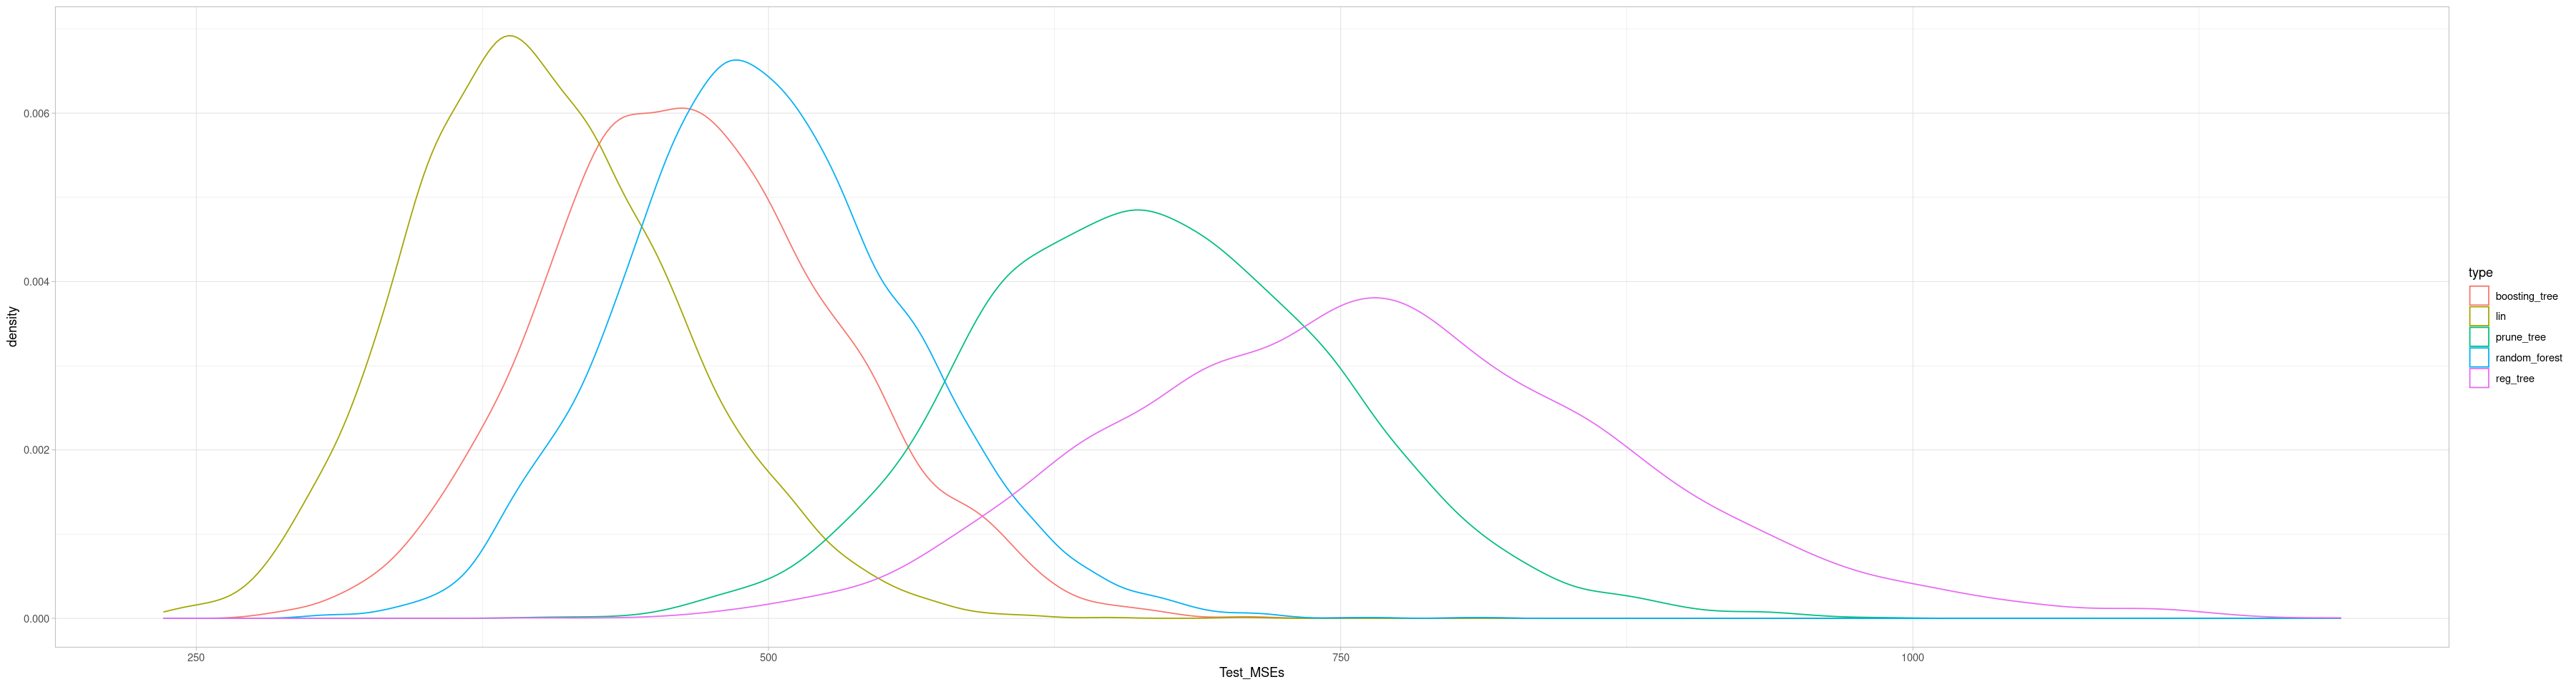

In [4]:
ggplot(data = full_tibble) +
    geom_density(aes(x = Test_MSEs, col = type)) +
    theme_light()

print(paste0("This graph was based on ", dim(full_tibble)[1]/5, " simulation runs."))

As you can see boosting tree performs best out of the tree based algorithms. The fact that linear regression performs even better is concerning for an application setting similar to the generated data, but does not invalidate the comparative qualities between the tree methods.